
Cloning CIFAR-10 Dataset Repository

In [1]:
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 46.09 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Updating files: 100% (60001/60001), done.


List Files in CIFAR-10 Test Dataset Folder

In [2]:
!ls CIFAR-10-images/test

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


Importing Necessary Libraries

In [3]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Listing Categories in the CIFAR-10 Test Dataset

In [4]:
image_directory = 'CIFAR-10-images/test'
categories = []

for category in os.listdir(image_directory):
    categories.append(category)

print(categories)

['horse', 'ship', 'frog', 'cat', 'automobile', 'dog', 'bird', 'deer', 'truck', 'airplane']


Loading Training Data from CIFAR-10 Train Dataset

In [5]:
image_directory = 'CIFAR-10-images/train'

# List to store the training data
training_data = []

for category in os.listdir(image_directory):
    category_path = os.path.join(image_directory, category)
    class_label = categories.index(category)

    for image_filename in tqdm(os.listdir(category_path)):
        if image_filename.endswith(".jpg"):
            image_path = os.path.join(category_path, image_filename)
            image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            training_data.append([image_array, class_label])

print(f"\nTotal Images in TRAIN_DATA: {len(training_data)}")

100%|██████████| 5000/5000 [00:00<00:00, 22373.34it/s]


Total Images in TRAIN_DATA: 50000


Displaying Random Samples from CIFAR-10 Training Data

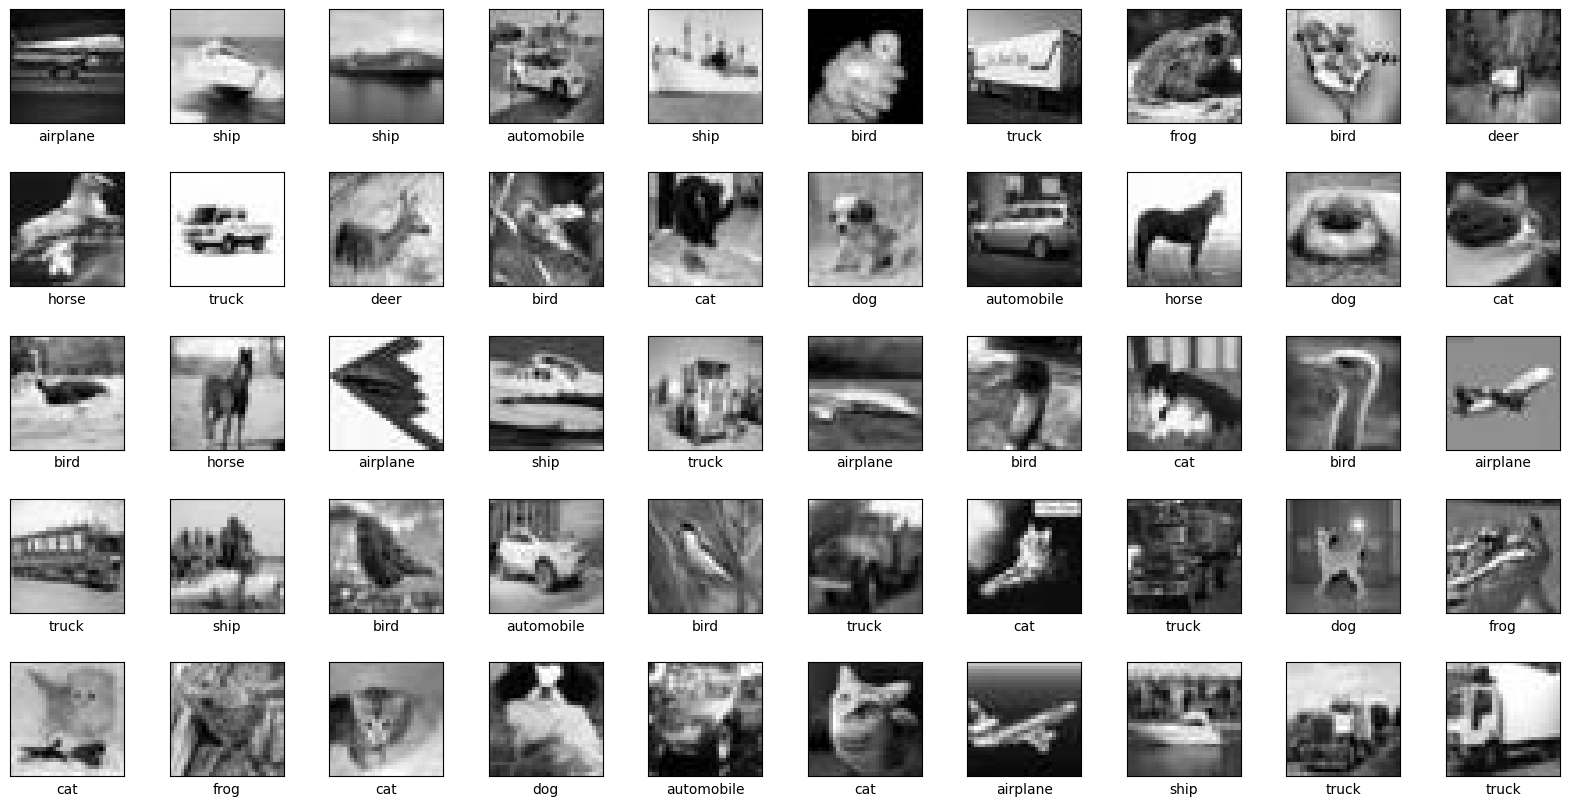

In [6]:
random.shuffle(training_data)

# Create a figure and an array of subplots
fig, axes = plt.subplots(5, 10, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    # Display the image from TRAIN_DATA
    if i < len(training_data):
        image = training_data[i][0]
        label_index = training_data[i][1]
        category = categories[label_index]
        ax.imshow(image, cmap='gray')
        ax.set_xlabel(category)

    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

Creating Cross-Validation Folds for CIFAR-10 Training Data

In [7]:
num_folds = 5
samples_per_fold = 500
folds = []

for i in range(num_folds):
    # Calculate the start and end indices for the current fold
    start_idx = i * samples_per_fold
    end_idx = (i + 1) * samples_per_fold
    fold_data = training_data[start_idx:end_idx]
    folds.append(fold_data)

print(f"Total samples: {len(training_data)}")
print(f"Number of folds: {num_folds}")
print(f"Samples per fold: {samples_per_fold}")
for i, fold in enumerate(folds):
    print(f"Fold {i + 1}: {len(fold)} samples")

Total samples: 50000
Number of folds: 5
Samples per fold: 500
Fold 1: 500 samples
Fold 2: 500 samples
Fold 3: 500 samples
Fold 4: 500 samples
Fold 5: 500 samples


Plotting K-NN Accuracies for Cross-Validation Folds

In [8]:
def plot_knn_accuracies(fold, k_values, accuracy_values):
    best_k_accuracy_pair = [0, 0]

    # Find the best K and its corresponding accuracy
    for k in k_values:
        accuracies = accuracy_values[k]
        max_accuracy = max(accuracies)
        if max_accuracy > best_k_accuracy_pair[1]:
            best_k_accuracy_pair = [k, max_accuracy]

        # Plot individual accuracy points for different K values
        plt.scatter([k] * len(accuracies), accuracies)

    # Calculate the trend line with error bars corresponding to standard deviation
    accuracies_mean = np.array([np.mean(v) for k, v in sorted(accuracy_values.items())])
    accuracies_std = np.array([np.std(v) for k, v in sorted(accuracy_values.items())])

    # Create the plot
    plt.errorbar(k_values, accuracies_mean, yerr=accuracies_std)
    plt.title(f"Cross-validation   fold={fold}   K={best_k_accuracy_pair[0]}   Accuracy = {best_k_accuracy_pair[1]:.2f}")
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.show()

K-Nearest Neighbors (K-NN) Cross-Validation and Accuracy Calculation

In [9]:
# Define k values for k-NN
k_values = [1, 3, 5, 7, 9]

# Initialize dictionaries to store error rates for L1 and L2 distances
k_values_error_l1 = {k: [] for k in k_values}
k_values_error_l2 = {k: [] for k in k_values}

# Lists to store midpoint accuracies for L1 and L2 distances
midpoint_l1_accuracies = []
midpoint_l2_accuracies = []

# Loop through 5-fold cross-validation
for i in range(5):
    train_set = [folds[j] for j in range(5) if j != i]  # Use all folds except the validation fold
    validation_set = folds[i]

    # Lists to store accuracy for different k values
    l1_accuracies = []
    l2_accuracies = []

    for k in k_values:
        l1_correct = 0
        l2_correct = 0
        total = 0

        # Iterate through validation data
        for v in tqdm(validation_set):
            v_img = v[0]
            v_label = v[1]
            l1_scores = []
            l2_scores = []

            # Compare with each data point in the training set
            for fold in train_set:
                for t in fold:
                    t_img = t[0]
                    t_label = t[1]

                    # Calculate L1 and L2 distances
                    l1_dist = np.sum(np.abs(t_img - v_img))
                    l1_scores.append((l1_dist, t_label))

                    l2_dist = np.sqrt(np.sum((t_img - v_img) ** 2))
                    l2_scores.append((l2_dist, t_label))

            # Sort distances and find k-nearest neighbors
            sorted_l1_scores = sorted(l1_scores, key=lambda x: x[0])[:k]
            l1_neighbors = [s[1] for s in sorted_l1_scores]
            l1_prediction = max(set(l1_neighbors), key=l1_neighbors.count)

            sorted_l2_scores = sorted(l2_scores, key=lambda x: x[0])[:k]
            l2_neighbors = [s[1] for s in sorted_l2_scores]
            l2_prediction = max(set(l2_neighbors), key=l2_neighbors.count)

            # Check if the prediction matches the true label
            if l1_prediction == v_label:
                l1_correct += 1
            if l2_prediction == v_label:
                l2_correct += 1

            total += 1

        # Calculate and append accuracy for both L1 and L2 distances
        l1_accuracy = l1_correct / total
        l1_accuracies.append(l1_accuracy)
        k_values_error_l1[k].append(l1_accuracy)

        l2_accuracy = l2_correct / total
        l2_accuracies.append(l2_accuracy)
        k_values_error_l2[k].append(l2_accuracy)

        print("Fold {}, k = {}, L1 accuracy = {:.2f}%, L2 accuracy = {:.2f}%".format(i, k, l1_accuracy * 100, l2_accuracy * 100))

    # Calculate and append midpoint accuracies for L1 and L2 distances
    min_l1_accuracy = min(l1_accuracies)
    max_l1_accuracy = max(l1_accuracies)
    midpoint_l1_accuracy = (min_l1_accuracy + max_l1_accuracy) / 2
    midpoint_l1_accuracies.append(midpoint_l1_accuracy)

    min_l2_accuracy = min(l2_accuracies)
    max_l2_accuracy = max(l2_accuracies)
    midpoint_l2_accuracy = (min_l2_accuracy + max_l2_accuracy) / 2
    midpoint_l2_accuracies.append(midpoint_l2_accuracy)

100%|██████████| 500/500 [00:22<00:00, 22.17it/s]


Fold 0, k = 1, L1 accuracy = 15.20%, L2 accuracy = 13.40%


100%|██████████| 500/500 [00:22<00:00, 21.91it/s]


Fold 0, k = 3, L1 accuracy = 15.00%, L2 accuracy = 13.80%


100%|██████████| 500/500 [00:23<00:00, 21.55it/s]


Fold 0, k = 5, L1 accuracy = 15.80%, L2 accuracy = 13.60%


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]


Fold 0, k = 7, L1 accuracy = 15.40%, L2 accuracy = 14.00%


100%|██████████| 500/500 [00:25<00:00, 19.67it/s]


Fold 0, k = 9, L1 accuracy = 15.20%, L2 accuracy = 15.20%


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


Fold 1, k = 1, L1 accuracy = 14.80%, L2 accuracy = 11.60%


100%|██████████| 500/500 [00:25<00:00, 19.34it/s]


Fold 1, k = 3, L1 accuracy = 13.80%, L2 accuracy = 14.80%


100%|██████████| 500/500 [00:28<00:00, 17.45it/s]


Fold 1, k = 5, L1 accuracy = 16.80%, L2 accuracy = 15.00%


100%|██████████| 500/500 [00:23<00:00, 21.69it/s]


Fold 1, k = 7, L1 accuracy = 16.40%, L2 accuracy = 14.60%


100%|██████████| 500/500 [00:23<00:00, 21.56it/s]


Fold 1, k = 9, L1 accuracy = 15.40%, L2 accuracy = 15.40%


100%|██████████| 500/500 [00:24<00:00, 20.52it/s]


Fold 2, k = 1, L1 accuracy = 16.20%, L2 accuracy = 14.20%


100%|██████████| 500/500 [00:22<00:00, 22.18it/s]


Fold 2, k = 3, L1 accuracy = 17.00%, L2 accuracy = 13.00%


100%|██████████| 500/500 [00:23<00:00, 21.69it/s]


Fold 2, k = 5, L1 accuracy = 17.00%, L2 accuracy = 13.00%


100%|██████████| 500/500 [00:21<00:00, 22.97it/s]


Fold 2, k = 7, L1 accuracy = 18.80%, L2 accuracy = 12.60%


100%|██████████| 500/500 [00:22<00:00, 22.60it/s]


Fold 2, k = 9, L1 accuracy = 18.40%, L2 accuracy = 14.60%


100%|██████████| 500/500 [00:22<00:00, 22.48it/s]


Fold 3, k = 1, L1 accuracy = 14.40%, L2 accuracy = 16.80%


100%|██████████| 500/500 [00:21<00:00, 23.59it/s]


Fold 3, k = 3, L1 accuracy = 16.20%, L2 accuracy = 14.60%


100%|██████████| 500/500 [00:22<00:00, 22.57it/s]


Fold 3, k = 5, L1 accuracy = 15.40%, L2 accuracy = 12.60%


100%|██████████| 500/500 [00:22<00:00, 22.61it/s]


Fold 3, k = 7, L1 accuracy = 17.20%, L2 accuracy = 14.20%


100%|██████████| 500/500 [00:21<00:00, 22.87it/s]


Fold 3, k = 9, L1 accuracy = 15.40%, L2 accuracy = 14.40%


100%|██████████| 500/500 [00:21<00:00, 22.91it/s]


Fold 4, k = 1, L1 accuracy = 19.60%, L2 accuracy = 15.40%


100%|██████████| 500/500 [00:22<00:00, 22.00it/s]


Fold 4, k = 3, L1 accuracy = 19.60%, L2 accuracy = 13.60%


100%|██████████| 500/500 [00:22<00:00, 22.67it/s]


Fold 4, k = 5, L1 accuracy = 19.20%, L2 accuracy = 15.80%


100%|██████████| 500/500 [00:21<00:00, 23.03it/s]


Fold 4, k = 7, L1 accuracy = 20.80%, L2 accuracy = 15.00%


100%|██████████| 500/500 [00:22<00:00, 21.78it/s]

Fold 4, k = 9, L1 accuracy = 20.40%, L2 accuracy = 16.20%


Calculating and Printing Average Accuracies for L1 and L2 Distances

In [10]:
# Initialize dictionaries to store average accuracies for L1 and L2 distances
avg_accuracies_l1 = {k: 0 for k in k_values}
avg_accuracies_l2 = {k: 0 for k in k_values}

# Calculate average accuracies across all folds
for k in k_values:
    avg_accuracy_l1 = sum(k_values_error_l1[k]) / len(k_values_error_l1[k])
    avg_accuracy_l2 = sum(k_values_error_l2[k]) / len(k_values_error_l2[k])

    avg_accuracies_l1[k] = avg_accuracy_l1
    avg_accuracies_l2[k] = avg_accuracy_l2

# Print average accuracies for L1 and L2 distances
for k in k_values:
    print("K = {}, Average L1 Accuracy: {:.2f}%".format(k, avg_accuracies_l1[k] * 100))
    print("K = {}, Average L2 Accuracy: {:.2f}%".format(k, avg_accuracies_l2[k] * 100))

K = 1, Average L1 Accuracy: 16.04%
K = 1, Average L2 Accuracy: 14.28%
K = 3, Average L1 Accuracy: 16.32%
K = 3, Average L2 Accuracy: 13.96%
K = 5, Average L1 Accuracy: 16.84%
K = 5, Average L2 Accuracy: 14.00%
K = 7, Average L1 Accuracy: 17.72%
K = 7, Average L2 Accuracy: 14.08%
K = 9, Average L1 Accuracy: 16.96%
K = 9, Average L2 Accuracy: 15.16%


Plotting K-NN Accuracy vs. K-Value for L1 and L2 Distances

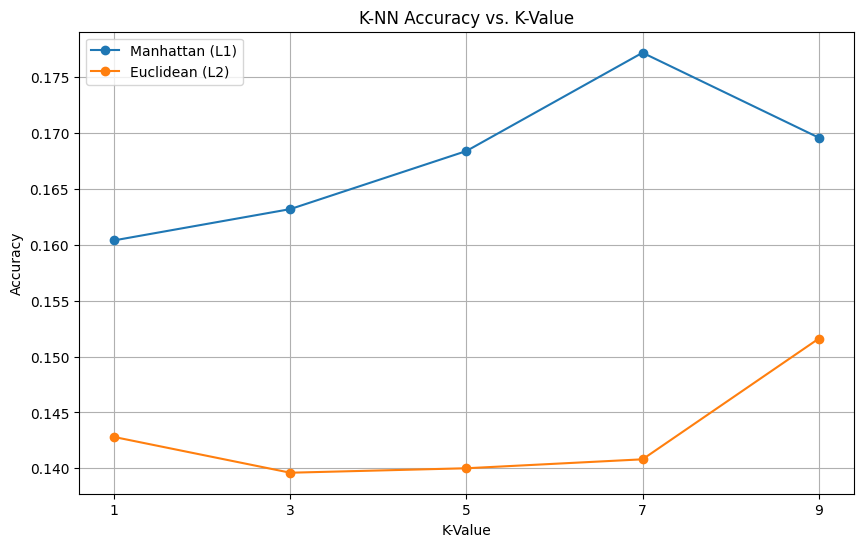

In [11]:
import matplotlib.pyplot as plt

# Define k values for k-NN
k_values = [1, 3, 5, 7, 9]

# Initialize dictionaries to store average accuracies for L1 and L2 distances
avg_accuracies_l1 = {k: 0 for k in k_values}
avg_accuracies_l2 = {k: 0 for k in k_values}

# Calculate average accuracies across all folds
for k in k_values:
    avg_accuracy_l1 = sum(k_values_error_l1[k]) / len(k_values_error_l1[k])
    avg_accuracy_l2 = sum(k_values_error_l2[k]) / len(k_values_error_l2[k])

    avg_accuracies_l1[k] = avg_accuracy_l1
    avg_accuracies_l2[k] = avg_accuracy_l2

# Create lists for plotting
k_values_list = list(k_values)
avg_accuracies_l1_list = [avg_accuracies_l1[k] for k in k_values]
avg_accuracies_l2_list = [avg_accuracies_l2[k] for k in k_values]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(k_values_list, avg_accuracies_l1_list, marker='o', label='Manhattan (L1)')
plt.plot(k_values_list, avg_accuracies_l2_list, marker='o', label='Euclidean (L2)')
plt.title('K-NN Accuracy vs. K-Value')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.xticks(k_values_list)
plt.legend()
plt.grid()
plt.show()

Discussion

In this assignment, we analyzed and compared the performance of Manhattan (L1) and Euclidean (L2) distances in the context of the CIFAR-10 dataset using 5-fold cross-validation. We considered various factors, including the dataset's characteristics, the nature of the features, and the complexity of the classes, to determine which distance calculation technique is better suited for this grayscale dataset. We also explored potential limitations and proposed improvements to enhance classification accuracy.


  
* Dataset Characteristics

  The CIFAR-10 dataset is a well-known benchmark in the field of computer vision, consisting of 50,000 32x32 color images categorized into ten different classes. However, in this particular analysis, the images have been converted to grayscale, effectively reducing the dimensionality of the dataset. This reduction in color information may influence the choice of distance metric.

* Feature Nature

  Grayscale images contain pixel intensity values, and when converted to a one-dimensional feature vector, they represent the brightness of each pixel. In this context, the choice between Manhattan (L1) and Euclidean (L2) distance is critical because it determines how we measure similarity between these feature vectors. L1 distance calculates the sum of absolute differences, while L2 distance calculates the square root of the sum of squared differences. The choice between L1 and L2 distance hinges on whether the dataset's characteristics favor one over the other.

* Complexity of Classes

  The CIFAR-10 dataset includes ten diverse classes, which may have varying levels of intra-class and inter-class variations. Some classes might have distinct and easily separable features, while others may exhibit significant overlap in feature space. This variation in class complexity can influence the performance of different distance metrics.

  Comparison of L1 and L2 Distances
  Let's analyze the results obtained through 5-fold cross-validation for different values of k (number of neighbors) using L1 and L2 distances:

  For K=1, both L1 and L2 distances yield similar accuracy, with L1 having a slightly higher average accuracy of 16.04% compared to L2's 14.28%.
  As K increases to 3, 5, 7, and 9, L1 consistently outperforms L2 in terms of average accuracy. L1 maintains its higher accuracy even as the number of neighbors increases, indicating that it might be a more suitable choice for this dataset.
  Implications
  The results suggest that L1 distance performs better than L2 distance for this grayscale CIFAR-10 dataset, particularly as the number of neighbors increases. This implies that the Manhattan distance, which emphasizes the sum of absolute differences, might be more appropriate for this specific dataset. This could be due to the nature of grayscale features, which might be better approximated by the L1 metric.

* Limitations and Future Improvements

  While L1 distance demonstrates its superiority, there are some limitations to consider:

  Hyperparameter Tuning: The choice of K (number of neighbors) can significantly impact the performance of the K-Nearest Neighbors algorithm. Further hyperparameter tuning could be explored to optimize K for both L1 and L2 distances.

  Feature Engineering: Feature engineering techniques, such as dimensionality reduction or data augmentation, can be applied to enhance the quality of the feature vectors, potentially improving classification accuracy.

  Advanced Classification Algorithms: Beyond K-Nearest Neighbors, more sophisticated classification algorithms, such as deep learning models, could be considered for improved performance.


In conclusion, for this grayscale CIFAR-10 dataset, Manhattan (L1) distance appears to be the more suitable choice for K-Nearest Neighbors classification, as it consistently outperforms Euclidean (L2) distance in terms of accuracy. Further research could focus on optimizing hyperparameters and exploring advanced techniques to enhance classification performance.

K-Nearest Neighbors (K-NN) Predictions on Test Images

In [12]:
def knn_predict(test_image, train_data, k, distance_metric):
    distances = []
    for train_image, label in train_data:
        if distance_metric == 'l1':
            distance = np.sum(np.abs(train_image - test_image))
        elif distance_metric == 'l2':
            distance = np.sqrt(np.sum((train_image - test_image) ** 2))
        distances.append((distance, label))

    # Sort distances and select the top k neighbors
    sorted_distances = sorted(distances, key=lambda x: x[0])
    k_nearest = [label for _, label in sorted_distances[:k]]

    # Predict the label based on the majority class among the k-nearest neighbors
    predicted_label = max(set(k_nearest), key=k_nearest.count)
    return predicted_label

# Test images directory
test_image_directory = 'CIFAR-10-images/test'

# Load test images
test_images = []
for image_filename in os.listdir(test_image_directory):
    if image_filename.endswith(".jpg"):
        image_path = os.path.join(test_image_directory, image_filename)
        test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        test_images.append(test_image)

# Set k value and distance metric
k = 5
distance_metric = 'l2'  # You can change this to 'l1' if needed

# Make predictions on test images and display the top 5 predictions
for test_image in test_images:
    predictions = []
    for i, fold in enumerate(folds):
        train_data = [item for sublist in folds[:i] + folds[i+1:] for item in sublist]
        predicted_label = knn_predict(test_image, train_data, k, distance_metric)
        predictions.append((predicted_label, categories[predicted_label]))

    # Sort predictions by frequency and select the top 5
    top_5_predictions = [label for label, _ in sorted(predictions, key=lambda x: predictions.count(x), reverse=True)[:5]]

    # Display the test image and its top 5 predictions
    plt.figure()
    plt.imshow(test_image, cmap='gray')
    plt.title(f"Top 5 Predictions: {', '.join([categories[label] for label in top_5_predictions])}")
    plt.show()


K-Nearest Neighbors (K-NN) Predictions on a Random Test Image and Visualization

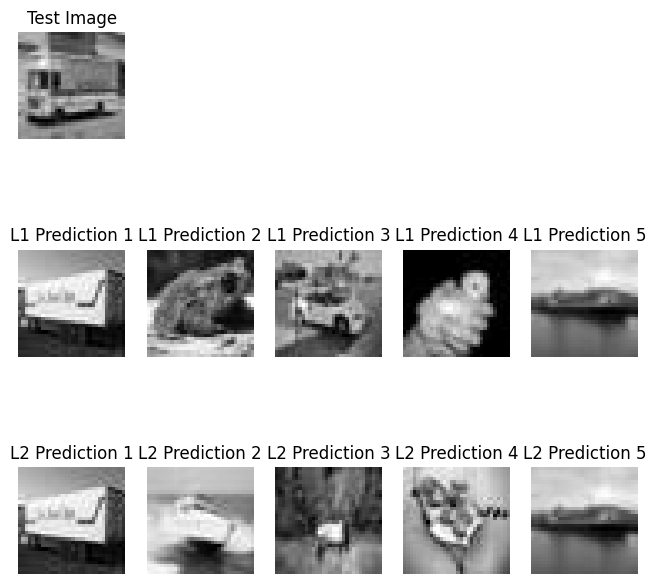

In [13]:
import os
import random
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Function to load a random test image
def load_random_test_image(test_dir):
    subfolders = [os.path.join(test_dir, folder) for folder in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, folder))]
    random_folder = random.choice(subfolders)
    random_image_filename = random.choice(os.listdir(random_folder))
    random_image_path = os.path.join(random_folder, random_image_filename)
    random_image_array = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
    return random_image_array

# Function to make k-NN predictions for a test image
def knn_predict(test_image, k):
    l1_scores = []
    l2_scores = []

    for t in training_data:
        t_img = t[0]
        t_label = t[1]
        l1_dist = np.sum(np.abs(t_img - test_image))
        l1_scores.append((l1_dist, t_label))

        l2_dist = np.sqrt(np.sum((t_img - test_image) ** 2))
        l2_scores.append((l2_dist, t_label))

    sorted_l1_scores = sorted(l1_scores, key=lambda x: x[0])[:k]
    l1_neighbors = [s[1] for s in sorted_l1_scores]

    sorted_l2_scores = sorted(l2_scores, key=lambda x: x[0])[:k]
    l2_neighbors = [s[1] for s in sorted_l2_scores]

    l1_prediction = max(set(l1_neighbors), key=l1_neighbors.count)
    l2_prediction = max(set(l2_neighbors), key=l2_neighbors.count)

    return l1_prediction, l2_prediction

# Load a random test image
random_test_image = load_random_test_image('CIFAR-10-images/test')

# Make predictions for the random test image
k_value = 5  # Choose the value of k for predictions
l1_prediction, l2_prediction = knn_predict(random_test_image, k_value)

# Display the test image
plt.figure(figsize=(8, 8))
plt.subplot(3, 5, 1)
plt.title("Test Image")
plt.imshow(random_test_image, cmap='gray')
plt.axis('off')

# Display the top 5 predicted images
top_5_l1_predictions = [item[0] for item in Counter(l1_neighbors).most_common(5)]
top_5_l2_predictions = [item[0] for item in Counter(l2_neighbors).most_common(5)]

for i in range(min(5, len(top_5_l1_predictions))):
    plt.subplot(3, 5, i + 6)
    plt.title(f"L1 Prediction {i + 1}")
    plt.imshow(training_data[top_5_l1_predictions[i]][0], cmap='gray')
    plt.axis('off')

for i in range(min(5, len(top_5_l2_predictions))):
    plt.subplot(3, 5, i + 11)
    plt.title(f"L2 Prediction {i + 1}")
    plt.imshow(training_data[top_5_l2_predictions[i]][0], cmap='gray')
    plt.axis('off')

plt.show()